# Discrete hedging experiment for a European Call option under the Heston model

> TODO: Add a description to the experiment

> Under the Heston but we are using the Black-Scholes delta for hedging

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np
import pandas as pd

from jax import vmap, grad, jit
import jax.numpy as jnp
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science','no-latex'])

from jaxfin.models.heston import UnivHestonModel
from jaxfin.price_engine.black_scholes import european_price, delta_european
from jaxfin.price_engine.fft import fourier_inv_call, delta_call_fourier

from src.experimental.bs_iv import IV_brent
import py_vollib_vectorized

In [3]:
seed = 42

$$
S(0) = 100 \\
\sigma = 0.2 \\
\mu = 0.00 \\
$$

Let set $N = 252$, which means that we are rebalancing our portfolio daily.

In [4]:
# Initialize the Univariate Heston Model
s0 = 100.0
v0 = 0.04
mean = 0.0
kappa = 1.0
theta = 0.04
sigma = 0.1
rho = -0.7

heston_model = UnivHestonModel(s0, v0, mean, kappa, theta, sigma, rho)

In [5]:
maturity = 1.0
N = 252
dt = maturity / N
n_sim = 100

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

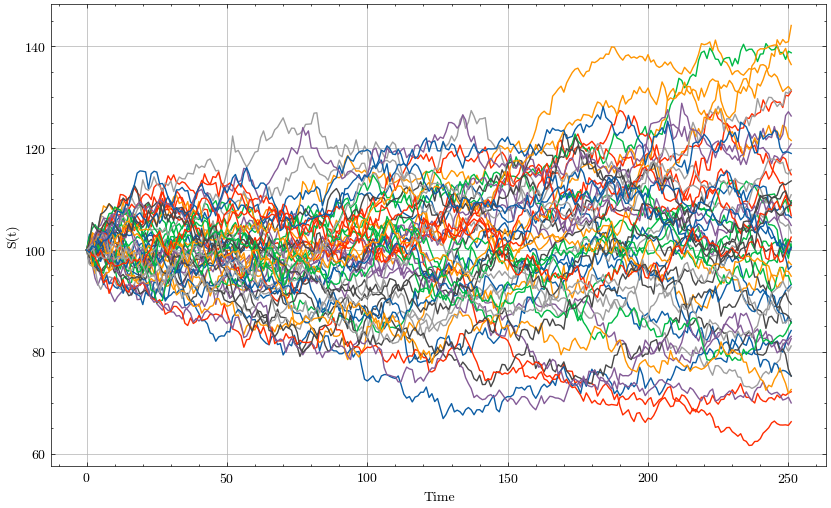

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(stock_paths[:, :50])
plt.ylabel('S(t)')
plt.xlabel('Time')
plt.grid()
plt.show()

In [7]:
discount_rate = 0.0
dividends = 0.0

## Hedging experiment without transaction costs

In [8]:
ticksize = 0.00
K = 100
maturity = 1.0
N = 252
n_sim = 100

v_fourier_delta_call = vmap(delta_call_fourier, in_axes=(0, None, None, None, None, None, None, None, None))
v_v_fourier_delta_call = vmap(v_fourier_delta_call, in_axes=(None, None, None, 0, None, None, None, None, None))
v_fourier_inv_call = vmap(fourier_inv_call, in_axes=(0, None, None, None, None, None, None, None, None))
v_v_fourier_inv_call = vmap(v_fourier_inv_call, in_axes=(None, None, None, 0, None, None, None, None, None))

In [9]:
def heston_vega(s0, K, T, v, mu, theta, sigma, kappa, rho):
    return grad(fourier_inv_call, argnums=3)(s0, K, T, v, mu, theta, sigma, kappa, rho)

_v_heston_vega = vmap(heston_vega, in_axes=(0, None, None, None, None, None, None, None, None))
v_heston_vega = vmap(_v_heston_vega, in_axes=(None, None, None, 0, None, None, None, None, None))

In [10]:
def get_heston_deltas(stock_paths, var_process, K, T, mu, theta, sigma, kappa, rho, N):
    dt = maturity / N
    deltas = [v_v_fourier_delta_call(stock_paths[0], K, T, var_process[0], mu, theta, sigma, kappa, rho).diagonal()]
    deltas_ = [v_v_fourier_delta_call(
        stock_paths[i], 
        K, 
        T - i * dt, 
        var_process[i - 1], 
        mu, 
        theta, 
        sigma, 
        kappa, 
        rho).diagonal() for i in range(1, N)]
    return jnp.asarray(deltas + deltas_)

def get_heston_vegas(stock_paths, var_process, K, T, mu, theta, sigma, kappa, rho, N):
    dt = maturity / N
    vegas = [v_heston_vega(stock_paths[0], K, T, var_process[0], mu, theta, sigma, kappa, rho).diagonal()]
    vegas_ = [v_heston_vega(
        stock_paths[i], 
        K, 
        T - i * dt, 
        var_process[i - 1], 
        mu, 
        theta, 
        sigma, 
        kappa, 
        rho).diagonal() for i in range(1, N)]
    return jnp.asarray(vegas + vegas_)

def get_heston_hedging_deltas(stock_paths, var_process, K, T, mu, theta, sigma, kappa, rho, N):
    vegas = get_heston_vegas(stock_paths, var_process, K, T, mu, theta, sigma, kappa, rho, N)
    deltas = get_heston_deltas(stock_paths, var_process, K, T, mu, theta, sigma, kappa, rho, N)

    return deltas + (rho * sigma / stock_paths) * vegas


In [11]:
def get_transaction_costs(ticksize, ddelta):
    return ticksize * (jnp.abs(ddelta) + 0.01 * ddelta**2)

In [12]:
def hedge_experiment_loop(stock_paths, var_process, K, mu, sigma, maturity, N, ticksize=0.00):
    deltas = get_heston_hedging_deltas(stock_paths, var_process, K, maturity, mu, theta, sigma, kappa, rho, N)
    cs = [v_v_fourier_inv_call(stock_paths[i], K, maturity - i * dt, var_process[i], mu, theta, sigma, kappa, rho).diagonal() for i in range(0, N)]
    b = [cs[0] - deltas[0] * stock_paths[0]]
    vs = [cs[0]]

    for i in range(1, N):
        ddelta = deltas[i] - deltas[i - 1] if i != N - 1 else deltas[i]
        transaction_costs = get_transaction_costs(ticksize, ddelta)

        vs.append(deltas[i - 1] * stock_paths[i] + b[i - 1])
        b.append(vs[i] - deltas[i] * stock_paths[i] - transaction_costs)
        
    hedge_error = jnp.asarray(vs) - jnp.maximum(stock_paths - K, 0)

    return jnp.nanmean(hedge_error[-1]), jnp.nanstd(hedge_error[-1]) / jnp.asarray(cs)[0, 0]

### Experiments

In [13]:
results = {
    'Strike': [],
    'Sigma': [],
    'Maturity': [],
    'Rebalancing_freq': [],
    'E_PL_T': [],
    'Std_PL_T': []
}

In [14]:
def update_results(stock_paths, var_process, K, discount_rate, sigma, maturity, N, ticksize=0.00):
    mean_hedge_error, std_hedge_error = hedge_experiment_loop(stock_paths, var_process, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

    results['Strike'].append(K)
    results['Sigma'].append(sigma)
    results['Maturity'].append(maturity)
    results['Rebalancing_freq'].append(N)
    results['E_PL_T'].append(mean_hedge_error)
    results['Std_PL_T'].append(std_hedge_error)

    print(f'The mean hedge error is: {mean_hedge_error}')
    print(f'The normalized std of the hedge error is: {std_hedge_error}')

    return results

In [15]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.06513337045907974
The normalized std of the hedge error is: 0.10677728801965714


Weekly rebalancing $n=52$

In [16]:
N = 52

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [17]:
var_process.shape

(52, 100)

In [18]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.09169959276914597
The normalized std of the hedge error is: 0.14777891337871552


#### Different strike prices

$$
S_0 = 100 \quad K = 80 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [19]:
K = 80
sigma = 0.1
maturity = 1.0
N = 252
n_sim = 100

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [20]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.05891745910048485
The normalized std of the hedge error is: 0.02034275233745575


Weekly rebalancing $n=52$

In [21]:
N = 52

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [22]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.06146359443664551
The normalized std of the hedge error is: 0.023180263116955757


$$
S_0 = 100 \quad K = 90 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [23]:
K = 90

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [24]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.11792959272861481
The normalized std of the hedge error is: 0.06540131568908691


Weekly rebalancing $n=52$

In [25]:
N = 52

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [26]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.04794631898403168
The normalized std of the hedge error is: 0.07188264280557632


$$
S_0 = 100 \quad K = 110 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [27]:
K = 110

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [28]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.009455389343202114
The normalized std of the hedge error is: 0.22009959816932678


Weekly rebalancing $n=52$

In [29]:
N = 52

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [30]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.07502332329750061
The normalized std of the hedge error is: 0.29167306423187256


$$
S_0 = 100 \quad K = 120 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [31]:
K = 120

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [32]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.03932376578450203
The normalized std of the hedge error is: 0.527782142162323


Weekly rebalancing $n=52$

In [33]:
N = 52

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [34]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.04698904603719711
The normalized std of the hedge error is: 0.5366823673248291


### Different maturities

$$
S_0 = 100 \quad K = 100 \quad T = 2.0 \quad n = 504
$$

In [35]:
K = 100
sigma = 0.1
N = 504
T = 2.0

heston_model = UnivHestonModel(s0, v0, mean, kappa, theta, sigma, rho)
stock_paths, var_process = heston_model.sample_paths(T, N, n_sim)

In [36]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: -0.2423650175333023
The normalized std of the hedge error is: 0.18891747295856476


Weekly rebalancing $n=104$

In [37]:
N = 104

stock_paths, var_process = heston_model.sample_paths(T, N, n_sim)

In [38]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: 0.2941451370716095
The normalized std of the hedge error is: 0.1992752104997635


$$
S_0 = 100 \quad K = 100 \quad T = 0.5 \quad n = 121
$$

In [39]:
N = 121
T = 0.5

heston_model = UnivHestonModel(s0, v0, mean, kappa, theta, sigma, rho)
stock_paths, var_process = heston_model.sample_paths(T, N, n_sim)

In [40]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: nan
The normalized std of the hedge error is: nan


Weekly rebalancing $n=104$

In [41]:
N = 26

stock_paths, var_process = heston_model.sample_paths(T, N, n_sim)

In [42]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: nan
The normalized std of the hedge error is: nan


$$
S_0 = 100 \quad K = 100 \quad T = 0.2 \quad n = 50
$$

In [43]:
N = 50
T = 0.2

heston_model = UnivHestonModel(s0, v0, mean, kappa, theta, sigma, rho)
stock_paths, var_process = heston_model.sample_paths(T, N, n_sim)

In [44]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: nan
The normalized std of the hedge error is: nan


Weekly rebalancing $n=10$

In [45]:
N = 10

stock_paths, var_process = heston_model.sample_paths(T, N, n_sim)

In [46]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: nan
The normalized std of the hedge error is: nan


In [47]:
res_df = pd.DataFrame.from_dict(results)
res_df

,Strike,Sigma,Maturity,Rebalancing_freq,E_PL_T,Std_PL_T
0,100,0.1,1.0,252,-0.06513337,0.10677729
1,100,0.1,1.0,52,0.09169959,0.14777891
2,80,0.1,1.0,252,0.05891746,0.020342752
3,80,0.1,1.0,52,0.061463594,0.023180263
4,90,0.1,1.0,52,-0.11792959,0.065401316
5,90,0.1,1.0,52,0.04794632,0.07188264
6,110,0.1,1.0,52,0.009455389,0.2200996
7,110,0.1,1.0,52,0.07502332,0.29167306
8,120,0.1,1.0,52,-0.039323766,0.52778214
9,120,0.1,1.0,52,-0.046989046,0.53668237


In [48]:
res_df.to_csv('./results/heston_delta_zero.csv')

### Hedging experiments with low transcation costs

### Experiments

In [49]:
ticksize = 0.01
K = 100
sigma = 0.1
maturity = 1.0
N = 252
n_sim = 100

heston_model = UnivHestonModel(s0, v0, mean, kappa, theta, sigma, rho)
stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [50]:
results = {
    'Strike': [],
    'Sigma': [],
    'Maturity': [],
    'Rebalancing_freq': [],
    'E_PL_T': [],
    'Std_PL_T': []
}

In [51]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.16488564014434814
The normalized std of the hedge error is: 0.10582055896520615


Weekly rebalancing $n=52$

In [52]:
N = 52

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [53]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.138229638338089
The normalized std of the hedge error is: 0.15229198336601257


#### Different strike prices

$$
S_0 = 100 \quad K = 80 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [54]:
K = 80
sigma = 0.1
maturity = 1.0
N = 252
n_sim = 100

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [55]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.020579902455210686
The normalized std of the hedge error is: 0.022205928340554237


Weekly rebalancing $n=52$

In [56]:
N = 52

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [57]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.019446881487965584
The normalized std of the hedge error is: 0.029756616801023483


$$
S_0 = 100 \quad K = 90 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [58]:
K = 90

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [59]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.10023865103721619
The normalized std of the hedge error is: 0.055713944137096405


Weekly rebalancing $n=52$

In [60]:
N = 52

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [61]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.11909276992082596
The normalized std of the hedge error is: 0.07263277471065521


$$
S_0 = 100 \quad K = 110 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [62]:
K = 110

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [63]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.21461212635040283
The normalized std of the hedge error is: 0.26715487241744995


Weekly rebalancing $n=52$

In [64]:
N = 52

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [65]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.15664425492286682
The normalized std of the hedge error is: 0.24385425448417664


$$
S_0 = 100 \quad K = 120 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [66]:
K = 120

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [67]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.07328014075756073
The normalized std of the hedge error is: 0.4535175561904907


Weekly rebalancing $n=52$

In [68]:
N = 52

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [69]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.06369432061910629
The normalized std of the hedge error is: 0.5145554542541504


### Different maturities

$$
S_0 = 100 \quad K = 100 \quad T = 2.0 \quad n = 504
$$

In [70]:
K = 100
sigma = 0.1
N = 504
T = 2.0

heston_model = UnivHestonModel(s0, v0, mean, kappa, theta, sigma, rho)
stock_paths, var_process = heston_model.sample_paths(T, N, n_sim)

In [71]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: -0.03179582580924034
The normalized std of the hedge error is: 0.1942501664161682


Weekly rebalancing $n=104$

In [72]:
N = 104

stock_paths, var_process = heston_model.sample_paths(T, N, n_sim)

In [73]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: -0.13606438040733337
The normalized std of the hedge error is: 0.18743309378623962


$$
S_0 = 100 \quad K = 100 \quad T = 0.5 \quad n = 121
$$

In [74]:
N = 121
T = 0.5

heston_model = UnivHestonModel(s0, v0, mean, kappa, theta, sigma, rho)
stock_paths, var_process = heston_model.sample_paths(T, N, n_sim)

In [75]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: nan
The normalized std of the hedge error is: nan


Weekly rebalancing $n=104$

In [76]:
N = 26

stock_paths, var_process = heston_model.sample_paths(T, N, n_sim)

In [77]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: nan
The normalized std of the hedge error is: nan


$$
S_0 = 100 \quad K = 100 \quad T = 0.2 \quad n = 50
$$

In [78]:
N = 50
T = 0.2

heston_model = UnivHestonModel(s0, v0, mean, kappa, theta, sigma, rho)
stock_paths, var_process = heston_model.sample_paths(T, N, n_sim)

In [79]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: nan
The normalized std of the hedge error is: nan


Weekly rebalancing $n=10$

In [80]:
N = 10

stock_paths, var_process = heston_model.sample_paths(T, N, n_sim)

In [81]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: nan
The normalized std of the hedge error is: nan


In [82]:
res_df = pd.DataFrame.from_dict(results)
res_df

,Strike,Sigma,Maturity,Rebalancing_freq,E_PL_T,Std_PL_T
0,100,0.1,1.0,252,-0.16488564,0.10582056
1,100,0.1,1.0,52,-0.13822964,0.15229198
2,80,0.1,1.0,252,0.020579902,0.022205928
3,80,0.1,1.0,52,0.019446881,0.029756617
4,90,0.1,1.0,52,0.10023865,0.055713944
5,90,0.1,1.0,52,0.11909277,0.072632775
6,110,0.1,1.0,52,-0.21461213,0.26715487
7,110,0.1,1.0,52,0.15664425,0.24385425
8,120,0.1,1.0,52,0.07328014,0.45351756
9,120,0.1,1.0,52,-0.06369432,0.51455545


In [83]:
res_df.to_csv('./results/heston_delta_low.csv')

### Hedging experiments with high transcation costs

### Experiments

In [84]:
ticksize = 0.05
K = 100
sigma = 0.1
maturity = 1.0
N = 252
n_sim = 100

heston_model = UnivHestonModel(s0, v0, mean, kappa, theta, sigma, rho)
stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [85]:
results = {
    'Strike': [],
    'Sigma': [],
    'Maturity': [],
    'Rebalancing_freq': [],
    'E_PL_T': [],
    'Std_PL_T': []
}

In [86]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.2556837797164917
The normalized std of the hedge error is: 0.09435374289751053


Weekly rebalancing $n=52$

In [87]:
N = 52

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [88]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.1170419305562973
The normalized std of the hedge error is: 0.14721272885799408


#### Different strike prices

$$
S_0 = 100 \quad K = 80 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [89]:
K = 80
sigma = 0.1
maturity = 1.0
N = 252
n_sim = 100

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [90]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.08919156342744827
The normalized std of the hedge error is: 0.0197297390550375


Weekly rebalancing $n=52$

In [91]:
N = 52

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [92]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.23060160875320435
The normalized std of the hedge error is: 0.03321351855993271


$$
S_0 = 100 \quad K = 90 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [93]:
K = 90

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [94]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.035021767020225525
The normalized std of the hedge error is: 0.06453609466552734


Weekly rebalancing $n=52$

In [95]:
N = 52

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [96]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.14044289290905
The normalized std of the hedge error is: 0.07866120338439941


$$
S_0 = 100 \quad K = 110 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [97]:
K = 110

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [98]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.024241900071501732
The normalized std of the hedge error is: 0.24108374118804932


Weekly rebalancing $n=52$

In [99]:
N = 52

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [100]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.07607275992631912
The normalized std of the hedge error is: 0.23872622847557068


$$
S_0 = 100 \quad K = 120 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [101]:
K = 120

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [102]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.06083454191684723
The normalized std of the hedge error is: 0.5107400417327881


Weekly rebalancing $n=52$

In [103]:
N = 52

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

In [104]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.0913916751742363
The normalized std of the hedge error is: 0.5202410221099854


### Different maturities

$$
S_0 = 100 \quad K = 100 \quad T = 2.0 \quad n = 504
$$

In [105]:
K = 100
sigma = 0.1
N = 504
T = 2.0

heston_model = UnivHestonModel(s0, v0, mean, kappa, theta, sigma, rho)
stock_paths, var_process = heston_model.sample_paths(T, N, n_sim)

In [106]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: -0.21951265633106232
The normalized std of the hedge error is: 0.19577406346797943


Weekly rebalancing $n=104$

In [107]:
N = 104

stock_paths, var_process = heston_model.sample_paths(T, N, n_sim)

In [108]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: -0.32865065336227417
The normalized std of the hedge error is: 0.2278016358613968


$$
S_0 = 100 \quad K = 100 \quad T = 0.5 \quad n = 121
$$

In [109]:
N = 121
T = 0.5

heston_model = UnivHestonModel(s0, v0, mean, kappa, theta, sigma, rho)
stock_paths, var_process = heston_model.sample_paths(T, N, n_sim)

In [110]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: nan
The normalized std of the hedge error is: nan


Weekly rebalancing $n=104$

In [111]:
N = 26

stock_paths, var_process = heston_model.sample_paths(T, N, n_sim)

In [112]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: nan
The normalized std of the hedge error is: nan


$$
S_0 = 100 \quad K = 100 \quad T = 0.2 \quad n = 50
$$

In [113]:
N = 50
T = 0.2

heston_model = UnivHestonModel(s0, v0, mean, kappa, theta, sigma, rho)
stock_paths, var_process = heston_model.sample_paths(T, N, n_sim)

In [114]:
results = update_results(stock_paths, var_process,K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: nan
The normalized std of the hedge error is: nan


Weekly rebalancing $n=10$

In [115]:
N = 10

stock_paths, var_process = heston_model.sample_paths(T, N, n_sim)

In [116]:
results = update_results(stock_paths, var_process, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: nan
The normalized std of the hedge error is: nan


In [117]:
res_df = pd.DataFrame.from_dict(results)
res_df

,Strike,Sigma,Maturity,Rebalancing_freq,E_PL_T,Std_PL_T
0,100,0.1,1.0,252,-0.25568378,0.09435374
1,100,0.1,1.0,52,-0.11704193,0.14721273
2,80,0.1,1.0,252,-0.08919156,0.019729739
3,80,0.1,1.0,52,-0.23060161,0.03321352
4,90,0.1,1.0,52,0.035021767,0.064536095
5,90,0.1,1.0,52,-0.1404429,0.0786612
6,110,0.1,1.0,52,-0.0242419,0.24108374
7,110,0.1,1.0,52,0.07607276,0.23872623
8,120,0.1,1.0,52,-0.060834542,0.51074004
9,120,0.1,1.0,52,-0.091391675,0.520241


In [118]:
res_df.to_csv('./results/heston_delta_high.csv')